### 8.**Has the average growth rate of confirmed cases significantly changed after July 2020?**

#### 🔹 Hypothesis:

* **H₀ (null):** There’s *no significant difference* in the average growth rate of confirmed cases before and after July 2020.
* **H₁ (alternative):** There *is* a significant difference.

#### 🔹 Test used:

```python
stats.ttest_ind(wave1, wave2)
```

You compared the mean of `GrowthRate_Confirmed` before and after `2020-07-01`.

#### 🔹 Result:

```
t-statistic: 8.890159693221538
p-value: 1.1594266862150047e-17
```

#### 🔹 Interpretation:

Since the **p-value is extremely small (< 0.05)**, we **reject H₀**.
This means the **average growth rate of confirmed cases significantly changed after July 2020** — likely dropped, showing that the spread slowed over time as shown in [6_US_Confirmed_VS_Death_Rates.ipynb](6_US_Confirmed_VS_Death_Rates.ipynb).

---

### 9.**Is there a significant relationship between confirmed cases and deaths?**

#### 🔹 Test used:

```python
corr, p = stats.pearsonr(us_daily['Confirmed'], us_daily['Deaths'])
```

This tests the **correlation** between total confirmed and total deaths.

#### 🔹 Result:

```
Correlation: 0.988
```

#### 🔹 Interpretation:

This is an **extremely strong positive correlation (r ≈ 0.99)**.
This means **as confirmed cases increase, deaths also increase very strongly and linearly**.

---

### 10.**Can we predict deaths from confirmed cases using a linear regression model?**

#### 🔹 Model:

```python
model = sm.OLS(y, X).fit()
```

* **y:** Deaths
* **X:** Confirmed (with a constant term)

#### 🔹 Results (key values):

| Statistic                     | Meaning                                              | Interpretation                                                                                       |
| ----------------------------- | ---------------------------------------------------- | ---------------------------------------------------------------------------------------------------- |
| **R² = 0.977**                | % of variance in deaths explained by confirmed cases | The model explains **97.7%** of the variation — excellent fit                                        |
| **Coef (Confirmed) = 0.0162** | The slope                                            | For every **1 additional confirmed case**, we expect **0.016 deaths** (≈ 1 death per 62 cases)       |
| **p < 0.001**                 | Significance of slope                                | The relationship is statistically significant                                                        |
| **Intercept = 50,730**        | Baseline                                             | When confirmed = 0, predicted deaths ≈ 50,730 (not meaningful in this context, just the y-intercept) |

**Conclusion:** Confirmed cases are a strong predictor of deaths in the U.S. COVID dataset.


In [1]:
import ast 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy import stats

# Set the path to the file you'd like to load
file_path = 'M:/3_datasets/covid_19_data.csv'

# Load the latest version
df = pd.read_csv(file_path)

#clean
df.columns = df.columns.str.replace(' ', '_')
df['Last_Update'] = pd.to_datetime(df['Last_Update'], format='mixed') 
df['ObservationDate']= pd.to_datetime(df['ObservationDate'])

df.set_index('SNo', inplace=True)

df['Country/Region']= df['Country/Region'].fillna('else')
df['Province/State']= df['Province/State'].fillna('Unknown')

df[['Confirmed','Deaths','Recovered']] = df[['Confirmed','Deaths','Recovered']].clip(lower=0) 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306429 entries, 1 to 306429
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ObservationDate  306429 non-null  datetime64[ns]
 1   Province/State   306429 non-null  object        
 2   Country/Region   306429 non-null  object        
 3   Last_Update      306429 non-null  datetime64[ns]
 4   Confirmed        306429 non-null  float64       
 5   Deaths           306429 non-null  float64       
 6   Recovered        306429 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 18.7+ MB


In [3]:
df_US= df[df['Country/Region'] == 'US']
df_US

,ObservationDate,Province/State,Country/Region,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
32,2020-01-22,Washington,US,2020-01-22 17:00:00,1.0,0.0,0.0
72,2020-01-23,Washington,US,2020-01-23 17:00:00,1.0,0.0,0.0
122,2020-01-24,Washington,US,2020-01-24 17:00:00,1.0,0.0,0.0
123,2020-01-24,Chicago,US,2020-01-24 17:00:00,1.0,0.0,0.0
165,2020-01-25,Washington,US,2020-01-25 17:00:00,1.0,0.0,0.0
...,...,...,...,...,...,...,...
306396,2021-05-29,Virginia,US,2021-05-30 04:20:55,675165.0,11160.0,0.0
306406,2021-05-29,Washington,US,2021-05-30 04:20:55,435849.0,5765.0,0.0
306409,2021-05-29,West Virginia,US,2021-05-30 04:20:55,161287.0,2792.0,0.0


In [4]:
df_grouped = df_US.groupby(['Province/State', 'ObservationDate'])[['Confirmed', 'Deaths', 'Recovered']].max().reset_index()

us_daily = df_grouped.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

us_daily

,ObservationDate,Confirmed,Deaths,Recovered
0,2020-01-22,1.0,0.0,0.0
1,2020-01-23,1.0,0.0,0.0
2,2020-01-24,2.0,0.0,0.0
3,2020-01-25,2.0,0.0,0.0
4,2020-01-26,5.0,0.0,0.0
...,...,...,...,...
489,2021-05-25,33166418.0,590941.0,0.0
490,2021-05-26,33190470.0,591950.0,0.0
491,2021-05-27,33217995.0,593288.0,0.0
492,2021-05-28,33239963.0,593963.0,0.0


In [5]:
us_daily['New_Confirmed'] = us_daily['Confirmed'].diff()
us_daily['New_Deaths'] = us_daily['Deaths'].diff()

us_daily['GrowthRate_Confirmed'] = us_daily['Confirmed'].pct_change() * 100
us_daily['GrowthRate_Deaths'] = us_daily['Deaths'].pct_change() * 100

us_daily= us_daily.fillna(0)
us_daily

,ObservationDate,Confirmed,Deaths,Recovered,New_Confirmed,New_Deaths,GrowthRate_Confirmed,GrowthRate_Deaths
0,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,2020-01-23,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,2020-01-24,2.0,0.0,0.0,1.0,0.0,100.000000,0.000000
3,2020-01-25,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,2020-01-26,5.0,0.0,0.0,3.0,0.0,150.000000,0.000000
...,...,...,...,...,...,...,...,...
489,2021-05-25,33166418.0,590941.0,0.0,22756.0,621.0,0.068659,0.105197
490,2021-05-26,33190470.0,591950.0,0.0,24052.0,1009.0,0.072519,0.170745
491,2021-05-27,33217995.0,593288.0,0.0,27525.0,1338.0,0.082930,0.226033
492,2021-05-28,33239963.0,593963.0,0.0,21968.0,675.0,0.066133,0.113773


In [6]:
# split our data into two periods
wave1 = us_daily.loc[us_daily['ObservationDate'] < '2020-07-01', 'GrowthRate_Confirmed']
wave2 = us_daily.loc[us_daily['ObservationDate'] >= '2020-07-01', 'GrowthRate_Confirmed']

t_stat, p_val = stats.ttest_ind(wave1.dropna(), wave2.dropna())
print("t-statistic:", t_stat)
print("p-value:", p_val)


t-statistic: 8.890159693221538
p-value: 1.1594266862150047e-17


In [7]:
corr, p = stats.pearsonr(us_daily['Confirmed'], us_daily['Deaths'])
print("Correlation:", corr)
print("p-value:", p)


Correlation: 0.9882045777281312
p-value: 0.0


## import statsmodels.api as sm notes

## 🧩 What `statsmodels` Does

`statsmodels` is used for:

* **Regression analysis** (linear, logistic, etc.)
* **Statistical tests** (t-tests, ANOVA, correlation tests)
* **Time series analysis** (ARIMA, seasonal decomposition)
* **Model diagnostics** (checking residuals, normality, etc.)

---

## ⚙️ Basic Workflow

Let’s take a simple example using **linear regression**:

### Example:

You want to see how well “Confirmed” cases predict “Deaths”:

```python
import statsmodels.api as sm

# 1. Define your variables
X = us_daily['Confirmed']  # independent variable
y = us_daily['Deaths']     # dependent variable

# 2. Add a constant (for the intercept term in regression)
X = sm.add_constant(X)

# 3. Fit an Ordinary Least Squares (OLS) regression model
model = sm.OLS(y, X).fit()

# 4. View the summary of the model
print(model.summary())
```

---

## 📈 Output Explanation (from `model.summary()`)

You’ll get a detailed table — here’s how to read it:

| Section            | Meaning                                                              |    |                                                                                     |
| ------------------ | -------------------------------------------------------------------- | -- | ----------------------------------------------------------------------------------- |
| **Dep. Variable**  | The variable you’re trying to predict (e.g. `Deaths`)                |    |                                                                                     |
| **R-squared**      | How well the model fits the data (1 = perfect fit)                   |    |                                                                                     |
| **coef**           | Regression coefficients — how much `Deaths` changes with `Confirmed` |    |                                                                                     |
| **P>               | t                                                                    | ** | The p-value for each variable — tests if that variable is statistically significant |
| **[0.025, 0.975]** | 95% confidence interval for each coefficient                         |    |                                                                                     |

---

## 🧠 Other Common Uses

| Task                | Function                                    |
| ------------------- | ------------------------------------------- |
| Linear regression   | `sm.OLS()`                                  |
| Logistic regression | `sm.Logit()`                                |
| ANOVA               | `sm.stats.anova_lm()`                       |
| Time series ARIMA   | `sm.tsa.ARIMA()`                            |
| Correlation tests   | `sm.stats.pearsonr()` or from `scipy.stats` |
| Residual plots      | `sm.graphics.plot_regress_exog()`           |

---

## 🧩 Tip

If you’re coming from `sklearn`, note that:

* `sklearn` is more about **machine learning** and prediction.
* `statsmodels` is more about **statistics** and explanation (it gives you p-values, confidence intervals, etc.).


In [8]:
import statsmodels.api as sm

X = sm.add_constant(us_daily['Confirmed'])
y = us_daily['Deaths']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 2.049e+04
Date:                Wed, 15 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:51:30   Log-Likelihood:                -5795.9
No. Observations:                 494   AIC:                         1.160e+04
Df Residuals:                     492   BIC:                         1.160e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.073e+04   1943.383     26.105      0.0

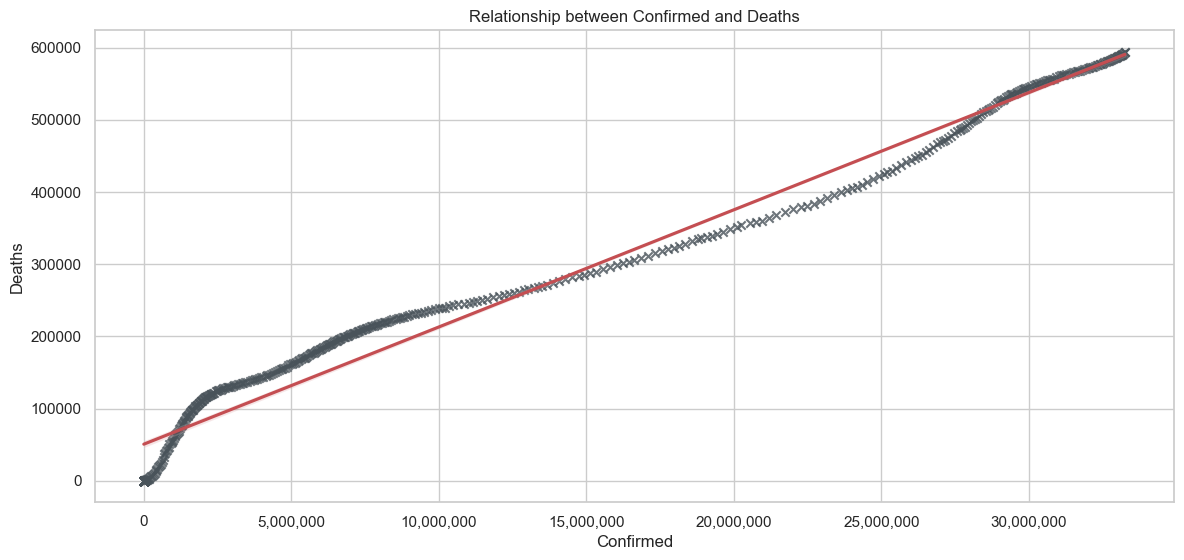

In [9]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))

ax= sns.regplot(x='Confirmed', y='Deaths', data=us_daily, marker="x", color="#49535a", line_kws=dict(color="r"))
plt.title("Relationship between Confirmed and Deaths")

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
